In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import logging
from src.docking import Dock, visualise_complex, fix_protein, visualise_interactions
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools
import pandas as pd
import rdkit
import seaborn as sns


/Users/fmaclean/miniconda3/envs/murd/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fmaclean/miniconda3/envs/murd/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/Users/fmaclean/miniconda3/envs/murd/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1112: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In this notebook, let's use the database from Takeuchi's paper to iterate through all possble R-groups and replace them with the top 500 most common substitions in medicinal chemistry.

Load all OSA molecules

In [2]:
xls = pd.ExcelFile('../data/Open Source Antibiotics Molecules.xlsx')
osa_mols = pd.read_excel(xls, 'All_OSA_Molecules')
osa_mols = osa_mols.set_index('OSA_ID')
osa_mols = osa_mols.dropna(subset=['SMILES_parent'])

In [3]:
mol_names = ["OSA_000373", "OSA_000754", "OSA_000742", "OSA_000786"]
mols = [Chem.MolFromSmiles(osa_mols.loc[name].SMILES_parent) for name in mol_names]

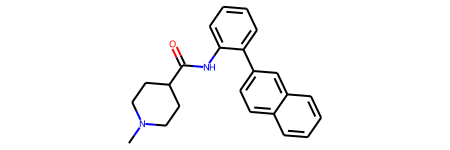

In [4]:
mols[1]

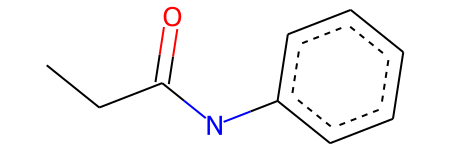

In [5]:
substruct = Chem.rdFMCS.FindMCS(mols)
assert mols[1].HasSubstructMatch(Chem.MolFromSmarts(substruct.smartsString)), "Substruct not in mol"
Chem.MolFromSmarts(substruct.smartsString)

In [6]:
import xmltodict
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ReplaceCore, GetMolFrags, ReplaceSubstructs, CombineMols
from itertools import product
import numpy as np
import pandas as pd

In [13]:
!cd ../data && wget https://zenodo.org/record/4741973/files/top500_R_replacements.xml

--2022-05-01 11:42:10--  https://zenodo.org/record/4741973/files/top500_R_replacements.xml
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124257 (121K) [application/octet-stream]
Saving to: ‘top500_R_replacements.xml’

top500_R_replacemen 100%[===================>] 121.34K  --.-KB/s    in 0.04s   

2022-05-01 11:42:11 (3.06 MB/s) - ‘top500_R_replacements.xml’ saved [124257/124257]



In [10]:
def smi2cansmi(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        for atm in mol.GetAtoms():
            atm.SetIsotope(0)
        return Chem.MolToSmiles(mol)
    else:
        return None
def generate_replacement_dictionary(replacement_xml_file):
    ifs = open(replacement_xml_file)
    xml = ifs.read()
    d = xmltodict.parse(xml)
    
    replacement_dict = defaultdict()
    for k in d['R_replacements']['center']:
        fl = k['first_layer']
        if type(fl) is not list:
            fl = [fl]
        first_layer = [a['@SMILES'] for a in fl]
        sl = [ x for x in [a.get('second_layer') for a in fl] if x]
        second_layer = []
        for row in sl:
            if type(row) is not list:
                row = [row]
            for r in row:
                second_layer.append(r['@SMILES'])
        replacement_dict[smi2cansmi(k['@SMILES'])] = [first_layer, second_layer]
    return replacement_dict

def get_replacements(smi, replacement_dict):
    cansmi = smi2cansmi(smi)
    return replacement_dict.get(cansmi, [[cansmi], [cansmi]])


def get_connect_idx(mol):
    return max([x.GetIsotope() for x in mol.GetAtoms()])

def prep_sidechain(smi):
    mol = Chem.MolFromSmiles(smi)
    rw_mol = Chem.RWMol(mol)
    remove_idx = -1
    for atm in rw_mol.GetAtoms():
        if atm.GetAtomicNum() == 0:
            remove_idx = atm.GetIdx()
            for nbr in atm.GetNeighbors():
                nbr.SetAtomMapNum(1)
    rw_mol.RemoveAtom(remove_idx)
    Chem.SanitizeMol(rw_mol)
    return rw_mol

def make_analogs(core,attach_pts,sidechains):
    prod_list = []
    for c in product(*sidechains):
        sidechain_mol_list = [prep_sidechain(x) for x in c]
        mol = Chem.RWMol(core)
        for start_atm,m in zip(attach_pts,sidechain_mol_list):
            mol = Chem.RWMol(CombineMols(mol,m))
            end_atm = -1
            for atm in mol.GetAtoms():
                if atm.GetAtomMapNum() == 1:
                    end_atm = atm.GetIdx()
            mol.AddBond(start_atm, end_atm, order=Chem.rdchem.BondType.SINGLE)
            for atm in mol.GetAtoms():
                atm.SetAtomMapNum(0)
        prod_list.append(Chem.MolToSmiles(mol))
    return prod_list

In [38]:
replacement_smiles

[['*CCN(C)C', '*CC', '*CCCN(C)C', '*CCNC', '*C(C)C', '*CCC'],
 ['*c1ccc2ccccc2c1',
  '*c1cccc2ccccc12',
  '*c1ccc(-c2ccccc2)cc1',
  '*c1cc2ccccc2s1',
  '*c1csc2ccccc12',
  '*c1ccc2ncccc2c1',
  '*c1cccc2cccnc12',
  '*c1cccc2ncccc12',
  '*c1cccc(-c2ccccc2)c1',
  '*c1cc2ccccc2o1',
  '*c1cc2ccccc2[nH]1']]

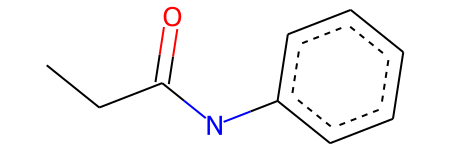

In [39]:
mol_core

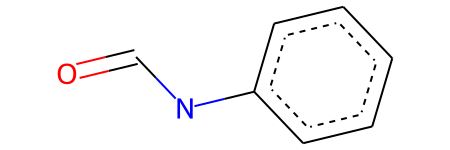

In [48]:
Chem.MolFromSmarts('[#6](-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)=[#8]')

In [61]:
import os
smiles_target = osa_mols.loc[mol_names[1]].SMILES_parent
core_smarts = substruct.smartsString

mol_core = Chem.MolFromSmarts('[#6](-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)=[#8]')
mol_target = Chem.MolFromSmiles(smiles_target)

if not os.path.exists("../data/top500_R_replacements.xml"):
    !cd ../data && wget https://zenodo.org/record/4741973/files/top500_R_replacements.xml
replacement_dict = generate_replacement_dictionary("../data/top500_R_replacements.xml")
use_second_layer = True

sidechain_mol = ReplaceCore(mol_target,mol_core,labelByIndex=True)
sidechain_frag_list = GetMolFrags(sidechain_mol,asMols=True)
attach_idx = [get_connect_idx(x) for x in sidechain_frag_list]
sidechain_smiles = [Chem.MolToSmiles(x) for x in sidechain_frag_list]
sidechain_smiles = sidechain_smiles + ['CN(C)CC[1*]']
replacement_smiles = [get_replacements(x,replacement_dict) for x in sidechain_smiles]

if use_second_layer:
    tmp_smiles = [a+b for a,b in replacement_smiles]
else:
    tmp_smiles = [x[0] for x in replacement_smiles]
replacement_smiles = tmp_smiles

clean_sidechain_smiles = [smi2cansmi(x) for x in sidechain_smiles]
tmp_list = []
for i,j in zip(clean_sidechain_smiles,replacement_smiles):
    tmp_list.append([i]+j)
replacement_smiles = tmp_list

analog_list = make_analogs(mol_core,attach_idx,replacement_smiles)
len(analog_list)

264

In [65]:
len(mol_list)

264

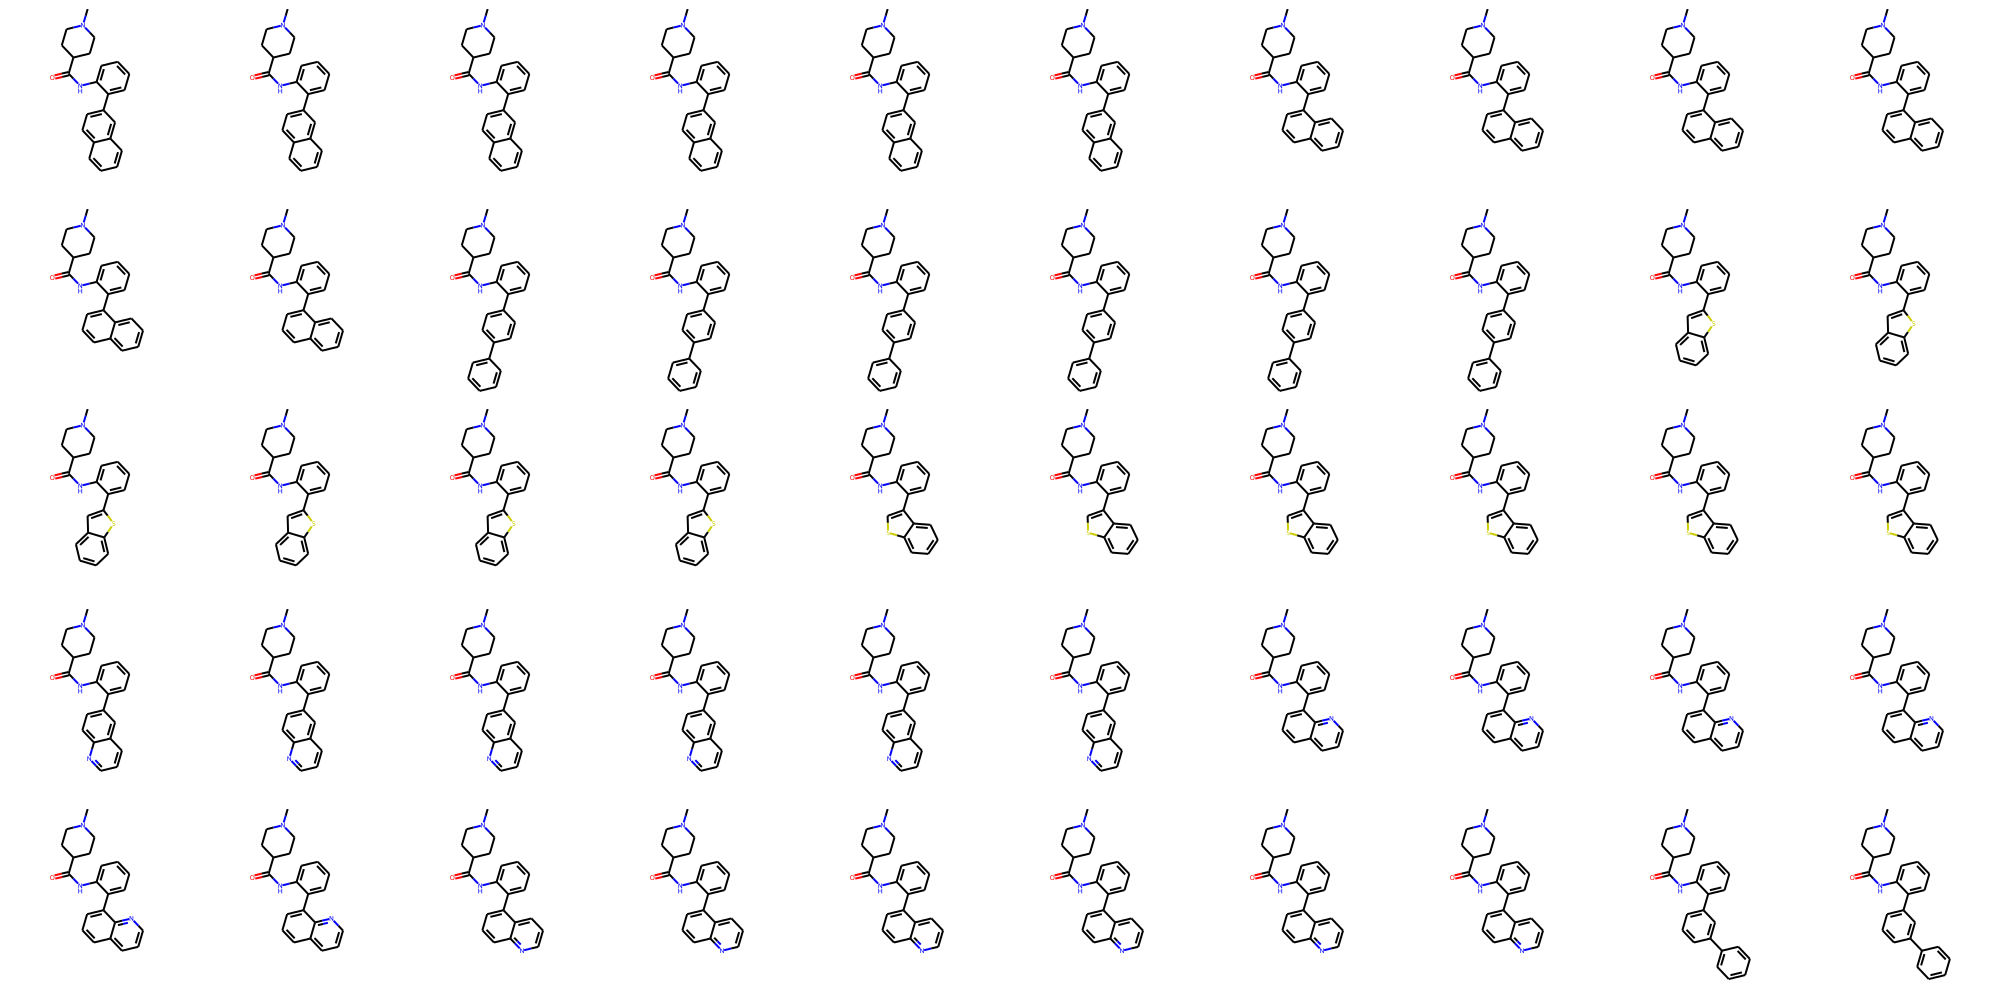

In [69]:
mol_list = [Chem.MolFromSmiles(x) for x in analog_list]
AllChem.Compute2DCoords(mol_core)
[AllChem.GenerateDepictionMatching2DStructure(x,mol_core) for x in mol_list]
Chem.Draw.MolsToGridImage(mol_list,molsPerRow=10)

In [70]:
outputs = []
ligand_sdf_files = []
prot = Dock.protein('protein_minus_ligand.fixed.pdb', fix_pdb=True)
for i, mol in enumerate(mol_list):
    smiles = Chem.MolToSmiles(mol).replace('*','')
    sdf_file = f'{i}.sdf'
    output = prot.dock(smiles, 
                       output_sdf_file=sdf_file,
                       autobox_ligand='_373.mol2', 
                       exhaustiveness=4, num_modes=1)
    output['lig_id'] = i
    output['sdf_file'] = sdf_file
    outputs.append(output)
    ligand_sdf_files.append(sdf_file)
    print(smiles, output.iloc[0].affinity)
    
outputs = pd.concat(outputs)

Finished!
adding gasteiger charges to peptide
protein_minus_ligand.fixed.pdb


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 0.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ccccc3c2)CC1 -9.20057583


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 1.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ccccc3c2)CC1 -9.17963791


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 2.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ccccc3c2)CC1 -9.18573761


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 3.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ccccc3c2)CC1 -9.17139721


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 4.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ccccc3c2)CC1 -9.19728279


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 5.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ccccc3c2)CC1 -9.20353699


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 6.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ccccc23)CC1 -8.30717182


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 7.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ccccc23)CC1 -8.30634022


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 8.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ccccc23)CC1 -8.31093788


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 9.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ccccc23)CC1 -8.30993462


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 10.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ccccc23)CC1 -8.30999184


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 11.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ccccc23)CC1 -8.30877686


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 12.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc(-c3ccccc3)cc2)CC1 -8.66440773


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 13.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc(-c3ccccc3)cc2)CC1 -8.64993


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 14.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc(-c3ccccc3)cc2)CC1 -8.67205143


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 15.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc(-c3ccccc3)cc2)CC1 -8.65884686


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 16.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc(-c3ccccc3)cc2)CC1 -8.67797089


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 17.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc(-c3ccccc3)cc2)CC1 -8.66501331


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 18.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3s2)CC1 -7.66545057


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 19.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3s2)CC1 -7.6551981


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 20.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3s2)CC1 -7.66308451


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 21.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3s2)CC1 -7.63832617


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 22.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3s2)CC1 -7.65595675


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 23.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3s2)CC1 -7.63468981


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 24.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2csc3ccccc23)CC1 -8.03616619


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 25.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2csc3ccccc23)CC1 -8.02575779


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 26.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2csc3ccccc23)CC1 -8.0304184


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 27.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2csc3ccccc23)CC1 -8.03756332


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 28.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2csc3ccccc23)CC1 -8.03747845


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 29.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2csc3ccccc23)CC1 -8.04660511


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 30.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ncccc3c2)CC1 -8.85787868


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 31.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ncccc3c2)CC1 -8.86807537


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 32.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ncccc3c2)CC1 -8.84919739


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 33.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ncccc3c2)CC1 -8.87913799


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 34.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ncccc3c2)CC1 -8.83428001


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 35.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2ccc3ncccc3c2)CC1 -8.80760765


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 36.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3cccnc23)CC1 -8.56224918


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 37.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3cccnc23)CC1 -8.55234718


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 38.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3cccnc23)CC1 -8.564044


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 39.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3cccnc23)CC1 -8.55128765


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 40.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3cccnc23)CC1 -8.5444622


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 41.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3cccnc23)CC1 -8.55701828


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 42.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ncccc23)CC1 -9.04079437


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 43.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ncccc23)CC1 -9.03003502


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 44.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ncccc23)CC1 -9.03379726


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 45.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ncccc23)CC1 -9.05680847


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 46.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ncccc23)CC1 -9.05821228


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 47.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc3ncccc23)CC1 -9.07154369


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 48.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc(-c3ccccc3)c2)CC1 -8.76348495


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 49.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc(-c3ccccc3)c2)CC1 -8.77549744


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 50.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc(-c3ccccc3)c2)CC1 -8.20604801


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 51.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc(-c3ccccc3)c2)CC1 -8.73638916


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 52.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc(-c3ccccc3)c2)CC1 -8.19318295


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 53.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cccc(-c3ccccc3)c2)CC1 -8.20300388


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 54.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3o2)CC1 -7.77271509


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 55.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3o2)CC1 -7.76019335


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 56.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3o2)CC1 -7.76168966


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 57.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3o2)CC1 -7.77158308


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 58.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3o2)CC1 -7.75872803


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 59.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3o2)CC1 -7.76477337


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 60.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3[nH]2)CC1 -8.41399479


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 61.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3[nH]2)CC1 -8.42060375


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 62.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3[nH]2)CC1 -8.39718628


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 63.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3[nH]2)CC1 -8.41860199


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 64.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3[nH]2)CC1 -8.42191982


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 65.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
CN1CCC(C(=O)Nc2ccccc2-c2cc3ccccc3[nH]2)CC1 -8.41272545


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 66.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNCC1 -9.15485477


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 67.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNCC1 -9.08935261


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 68.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNCC1 -9.06928921


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 69.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNCC1 -9.10009861


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 70.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNCC1 -9.09792233


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 71.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNCC1 -9.08694172


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 72.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNCC1 -8.33895493


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 73.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNCC1 -8.93837547


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 74.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNCC1 -8.55888653


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 75.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNCC1 -8.22700024


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 76.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNCC1 -9.24744415


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 77.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNCC1 -9.25217628


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 78.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNCC1 -8.57660007


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 79.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNCC1 -8.56501961


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 80.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNCC1 -8.60246468


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 81.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNCC1 -8.5775671


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 82.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNCC1 -8.59785652


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 83.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNCC1 -8.57558632


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 84.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNCC1 -7.99484968


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 85.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNCC1 -7.98892784


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 86.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNCC1 -7.6961236


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 87.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNCC1 -8.00932121


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 88.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNCC1 -8.14819145


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 89.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNCC1 -7.63713312


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 90.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNCC1 -7.83949232


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 91.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNCC1 -7.92387533


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 92.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNCC1 -7.83146954


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 93.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNCC1 -7.80965519


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 94.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNCC1 -7.74210072


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 95.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNCC1 -7.89733887


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 96.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNCC1 -8.719944


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 97.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNCC1 -8.7835865


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 98.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNCC1 -8.73451424


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 99.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNCC1 -8.77851391


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 100.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNCC1 -8.7945137


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 101.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNCC1 -8.81632519


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 102.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNCC1 -8.45260715


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 103.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNCC1 -8.50623608


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 104.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNCC1 -8.45267105


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 105.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNCC1 -8.53454304


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 106.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNCC1 -8.60278988


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 107.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNCC1 -8.54438591


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 108.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNCC1 -8.67671871


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 109.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNCC1 -8.65414238


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 110.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNCC1 -8.61467266


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 111.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNCC1 -9.09075451


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 112.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNCC1 -8.61455631


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 113.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNCC1 -9.04899788


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 114.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNCC1 -9.35607719


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 115.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNCC1 -9.01487732


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 116.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNCC1 -8.69678593


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 117.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNCC1 -8.84216213


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 118.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNCC1 -8.90952682


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 119.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNCC1 -8.92298508


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 120.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNCC1 -7.83337116


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 121.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNCC1 -8.49496365


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 122.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNCC1 -8.07620621


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 123.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNCC1 -8.46220589


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 124.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNCC1 -7.93059492


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 125.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNCC1 -8.52548504


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 126.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNCC1 -8.56489849


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 127.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNCC1 -8.69733334


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 128.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNCC1 -8.54113197


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 129.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNCC1 -8.55773067


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 130.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNCC1 -8.61936474


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 131.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNCC1 -8.62856579


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 132.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNC1 -8.89973354


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 133.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNC1 -8.94340229


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 134.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNC1 -8.90985203


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 135.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNC1 -8.97647858


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 136.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNC1 -8.99187183


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 137.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1CCNC1 -8.54105759


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 138.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNC1 -8.5738287


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 139.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNC1 -8.60738277


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 140.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNC1 -8.55172539


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 141.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNC1 -8.59582329


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 142.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNC1 -8.51973534


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 143.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1CCNC1 -8.64748573


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 144.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNC1 -8.76452255


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 145.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNC1 -8.63219261


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 146.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNC1 -8.69497013


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 147.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNC1 -8.65250206


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 148.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNC1 -8.4784317


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 149.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1CCNC1 -8.56632042


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 150.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNC1 -7.84519815


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 151.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNC1 -7.94470501


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 152.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNC1 -7.92595673


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 153.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNC1 -7.88054276


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 154.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNC1 -7.94043112


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 155.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1CCNC1 -7.92611742


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 156.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNC1 -8.46455002


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 157.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNC1 -8.30096149


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 158.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNC1 -8.31066036


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 159.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNC1 -8.32193279


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 160.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNC1 -8.45652103


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 161.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1CCNC1 -8.30100918


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 162.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNC1 -8.62696934


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 163.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNC1 -8.62363434


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 164.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNC1 -8.42371845


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 165.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNC1 -8.94887829


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 166.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNC1 -8.62730885


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 167.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1CCNC1 -8.63053513


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 168.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNC1 -8.13748741


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 169.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNC1 -7.96842003


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 170.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNC1 -8.20481682


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 171.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNC1 -8.12805939


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 172.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNC1 -8.19277287


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 173.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1CCNC1 -7.92561531


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 174.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNC1 -9.07238388


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 175.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNC1 -8.84123898


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 176.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNC1 -9.06355667


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 177.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNC1 -9.09036827


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 178.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNC1 -9.00268078


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 179.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1CCNC1 -9.03849411


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 180.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNC1 -9.27827835


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 181.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNC1 -8.80255413


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 182.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNC1 -8.73383904


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 183.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNC1 -8.78059959


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 184.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNC1 -9.15108776


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 185.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1CCNC1 -8.7936821


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 186.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNC1 -8.96172714


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 187.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNC1 -8.8943243


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 188.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNC1 -8.94296741


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 189.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNC1 -8.83665562


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 190.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNC1 -8.8274889


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 191.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1CCNC1 -8.93431473


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 192.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNC1 -8.55764484


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 193.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNC1 -8.6218729


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 194.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNC1 -8.5816803


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 195.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNC1 -8.53788185


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 196.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNC1 -8.53399086


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 197.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1CCNC1 -8.14908123


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 198.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1=CCNCC1 -9.18281746


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 199.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1=CCNCC1 -9.25302601


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 200.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1=CCNCC1 -9.05008125


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 201.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1=CCNCC1 -9.3760252


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 202.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1=CCNCC1 -9.37374783


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 203.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ccccc2c1)C1=CCNCC1 -9.41997433


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 204.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1=CCNCC1 -9.02011395


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 205.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1=CCNCC1 -8.97309589


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 206.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1=CCNCC1 -8.59197903


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 207.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1=CCNCC1 -9.00390434


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 208.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1=CCNCC1 -8.88180923


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 209.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ccccc12)C1=CCNCC1 -8.6609354


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 210.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1=CCNCC1 -8.91234779


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 211.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1=CCNCC1 -8.93386078


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 212.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1=CCNCC1 -8.95205212


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 213.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1=CCNCC1 -8.93571091


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 214.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1=CCNCC1 -8.92607212


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 215.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc(-c2ccccc2)cc1)C1=CCNCC1 -8.93708515


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 216.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1=CCNCC1 -8.26112652


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 217.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1=CCNCC1 -8.47913361


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 218.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1=CCNCC1 -7.86543083


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 219.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1=CCNCC1 -8.26898289


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 220.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1=CCNCC1 -8.50610352


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 221.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2s1)C1=CCNCC1 -8.30555725


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 222.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1=CCNCC1 -8.26402855


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 223.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1=CCNCC1 -8.30677509


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 224.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1=CCNCC1 -8.41014767


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 225.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1=CCNCC1 -8.28200817


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 226.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1=CCNCC1 -7.68876696


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 227.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1csc2ccccc12)C1=CCNCC1 -7.59727812


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 228.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1=CCNCC1 -8.87689018


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 229.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1=CCNCC1 -8.90664577


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 230.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1=CCNCC1 -8.50006866


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 231.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1=CCNCC1 -8.75409603


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 232.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1=CCNCC1 -8.97919464


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 233.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1ccc2ncccc2c1)C1=CCNCC1 -8.87371731


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 234.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1=CCNCC1 -8.29334354


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 235.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1=CCNCC1 -8.07656574


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 236.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1=CCNCC1 -8.04643345


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 237.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1=CCNCC1 -8.19934368


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 238.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1=CCNCC1 -7.95282602


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 239.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2cccnc12)C1=CCNCC1 -9.00314045


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 240.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1=CCNCC1 -8.89531708


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 241.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1=CCNCC1 -8.82707024


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 242.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1=CCNCC1 -8.92221165


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 243.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1=CCNCC1 -8.93836021


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 244.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1=CCNCC1 -8.93299389


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 245.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc2ncccc12)C1=CCNCC1 -8.95067978


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 246.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1=CCNCC1 -9.43460083


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 247.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1=CCNCC1 -9.3697052


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 248.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1=CCNCC1 -9.38858414


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 249.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1=CCNCC1 -9.45216465


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 250.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1=CCNCC1 -9.45472527


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 251.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cccc(-c2ccccc2)c1)C1=CCNCC1 -9.44817352


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 252.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1=CCNCC1 -9.1205225


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 253.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1=CCNCC1 -9.08312798


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 254.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1=CCNCC1 -9.0568676


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 255.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1=CCNCC1 -9.12119484


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 256.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1=CCNCC1 -9.11239624


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 257.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2o1)C1=CCNCC1 -9.12484264


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 258.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1=CCNCC1 -8.71554661


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 259.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1=CCNCC1 -8.72149181


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 260.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1=CCNCC1 -8.69160175


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 261.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1=CCNCC1 -8.71203136


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 262.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1=CCNCC1 -8.69830322


1 molecule converted


        smina         -r protein_minus_ligand.fixed.pdbqt -l lig.pdbqt         --num_modes 1 -o 263.sdf         --size_x 20 --size_y 20 --size_z 20         --exhaustiveness 4        --autobox_ligand _373.mol2
O=C(Nc1ccccc1-c1cc2ccccc2[nH]1)C1=CCNCC1 -8.69947243


,smiles,affinity,mol,lig_id,sdf_file
0,O=C(Nc1[c][c][c][c]c1-c1[c][c][c]c(-c2[c][c][c...,-9.454725,,250,250.sdf
0,O=C(Nc1[c][c][c][c]c1-c1[c][c][c]c(-c2[c][c][c...,-9.452165,,249,249.sdf
0,O=C(Nc1[c][c][c][c]c1-c1[c][c][c]c(-c2[c][c][c...,-9.448174,,251,251.sdf
0,O=C(Nc1[c][c][c][c]c1-c1[c][c][c]c(-c2[c][c][c...,-9.434601,,246,246.sdf
0,O=C(Nc1[c][c][c][c]c1-c1[c][c]c2[c][c][c][c]c2...,-9.419974,,203,203.sdf
...,...,...,...,...,...
0,[C]N1[C][C][C](C(=O)Nc2[c][c][c][c]c2-c2[c]c3[...,-7.655198,,19,19.sdf
0,[C]N1[C][C][C](C(=O)Nc2[c][c][c][c]c2-c2[c]c3[...,-7.638326,,21,21.sdf
0,O=C(Nc1[c][c][c][c]c1-c1[c]c2[c][c][c][c]c2s1)...,-7.637133,,89,89.sdf
0,[C]N1[C][C][C](C(=O)Nc2[c][c][c][c]c2-c2[c]c3[...,-7.634690,,23,23.sdf

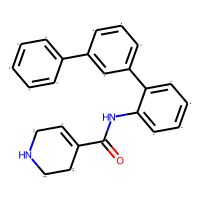
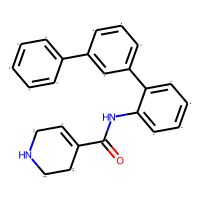
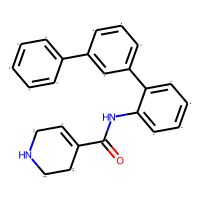
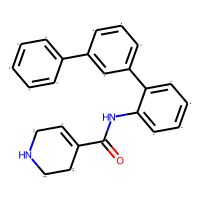
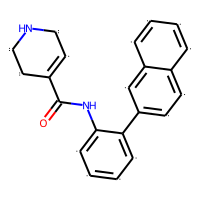
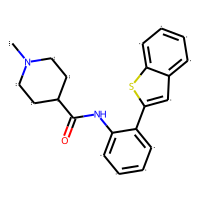
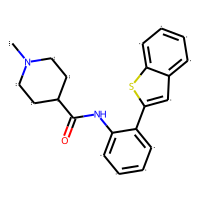
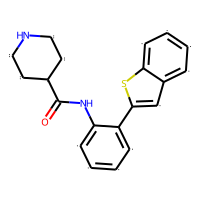
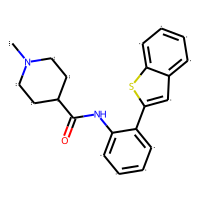
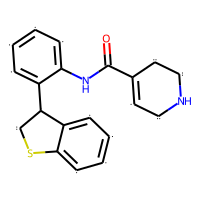

In [73]:
outputs.sort_values('affinity')